## Quasistatic fracture {#sec-quasistatic-fracture}

In this exercise, we apply the concepts learned in the @sec-cohesive-zone to simulate crack propagation in a plate under quasistatic loading. For this exercise, we will focus on using matrix-free solvers to solve the nonlinear problem of fracture. There are two reasons to chose matrix-free solvers:

-  Fracture simulations require a refined mesh around the crack tip and within the cohesive zone to correctly capture the stress singularity.
-  Unlike the sparse pattern of the stiffness matrix for unconstrained problems which is easy to find, we do not have a sparse pattern for cohesive elements. Later, we discuss more on this aspect.










In [107]:
# | code-fold: true
# | code-summary: "Code: Importing the essential libraries"
import jax

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")
import jax.numpy as jnp
from jax import Array

from femsolver.utils import auto_vmap
from femsolver import Mesh, Operator, element, sparse
from femsolver.plotting import STYLE_PATH, colors

from typing import Callable, Optional, Tuple

import equinox as eqx
import numpy as np

import matplotlib.pyplot as plt
import cmcrameri.cm as cmc


### Griffith's critical length

The critical length for plain strain condition is given by:

$$L_\text{G} = 2\mu \Gamma/\pi(1-\nu)\sigma_{\infty}^2$$

where $\mu$ is the shear modulus, $\Gamma$ is the fracture energy, $\nu$ is the
Poisson's ratio, and $\sigma_{\infty}$ is the stress at infinity.

For plain strain condition, the effective Young's modulus is given by:

$$E_\text{eff} = \frac{E}{1-\nu^2}$$

where $E$ is the Young's modulus and $\nu$ is the Poisson's ratio.

For a specimen stretched by a prestrain $\varepsilon^0$, the applied stress at
infinity is given by:

$$\sigma_{\infty} = \varepsilon^0 /E_\text{eff}$$


In [5]:
prestrain = 0.2
nu = 0.35

E = 106e3  # N/m^2
lmbda = nu * E / ((1 + nu) * (1 - 2 * nu))
mu = E / (2 * (1 + nu))

Gamma = 15  # J/m^2
sigma_c = 20e3  # N/m^2

print(f"mu: {mu} N/m^2")
print(f"lmbda: {lmbda} N/m^2")

sigma_inf = prestrain * E

L_G = 2 * mu * Gamma / (jnp.pi * (1 - nu) * sigma_inf**2)
print(f"L_G: {L_G} m")

mu: 39259.259259259255 N/m^2
lmbda: 91604.93827160491 N/m^2
L_G: 0.0012833006216085739 m


## Model setup

Using the above dimensions, we define a domain of length $20\times L_G$ and height $4\times L_G$. The plate has a pre-crack of length slightly larger than the Griffith fracture length $L_G$. For this exercise, we will use a pre-crack length of $1.2\times L_G$. 

We use triangular elements to discretize the domain.

In [6]:
# | code-fold: true
# | code-summary: "Code: Functions to generate the mesh"


def generate_mesh_with_line_elements(
    nx: int,
    ny: int,
    lxs: Tuple[float, float],
    lys: Tuple[float, float],
    curve_func: Optional[Callable[[jnp.ndarray, float], bool]] = None,
    tol: float = 1e-6,
) -> Tuple[jnp.ndarray, jnp.ndarray, Optional[jnp.ndarray]]:
    """
    Generates a 2D triangular mesh for a rectangle and optionally extracts
    1D line elements along a specified curve.

    Args:
        nx: Number of elements along the x-direction.
        ny: Number of elements along the y-direction.
        lxs: Tuple of the x-coordinates of the left and right edges of the rectangle.
        lys: Tuple of the y-coordinates of the bottom and top edges of the rectangle.
        curve_func: An optional callable that takes a coordinate array [x, y] and
                    a tolerance, returning True if the point is on the curve.
        tol: Tolerance for floating-point comparisons.

    Returns:
        A tuple containing:
        - coords (jnp.ndarray): Nodal coordinates, shape (num_nodes, 2).
        - elements_2d (jnp.ndarray): 2D triangular element connectivity.
        - elements_1d (jnp.ndarray | None): 1D line element connectivity, or None.
    """

    x = jnp.linspace(lxs[0], lxs[1], nx + 1)
    y = jnp.linspace(lys[0], lys[1], ny + 1)
    xv, yv = jnp.meshgrid(x, y, indexing="ij")
    coords = jnp.stack([xv.ravel(), yv.ravel()], axis=-1)

    def node_id(i, j):
        return i * (ny + 1) + j

    elements_2d = []
    for i in range(nx):
        for j in range(ny):
            n0 = node_id(i, j)
            n1 = node_id(i + 1, j)
            n2 = node_id(i, j + 1)
            n3 = node_id(i + 1, j + 1)
            elements_2d.append([n0, n1, n3])
            elements_2d.append([n0, n3, n2])
    elements_2d = jnp.array(elements_2d)

    # --- 2. Extract 1D elements if a curve function is provided ---
    if curve_func is None:
        return coords, elements_2d, None

    # Efficiently find all nodes on the curve using jax.vmap
    on_curve_mask = jax.vmap(lambda c: curve_func(c, tol))(coords)

    elements_1d = []
    # Iterate through all 2D elements to find edges on the curve
    for tri in elements_2d:
        # Define the three edges of the triangle
        edges = [(tri[0], tri[1]), (tri[1], tri[2]), (tri[2], tri[0])]
        for n_a, n_b in edges:
            # If both nodes of an edge are on the curve, add it to the set
            if on_curve_mask[n_a] and on_curve_mask[n_b]:
                # Sort to store canonical representation, e.g., (1, 2) not (2, 1)
                elements_1d.append(tuple(sorted((n_a, n_b))))

    if not elements_1d:
        return coords, elements_2d, jnp.array([], dtype=int)

    return coords, elements_2d, jnp.unique(jnp.array(elements_1d), axis=0)

In [8]:
Nx = 80  # Number of elements in X
Ny = 20  # Number of elements in Y
Lx = 20 * L_G  # Length in X
Ly = 4 * L_G  # Length in Y


crack_length = 1.2* L_G


# function identifies nodes on the cohesive line at y = 0. and x > 2.0
def cohesive_line(coord: jnp.ndarray, tol: float) -> bool:
    return jnp.logical_and(
        jnp.isclose(coord[1], 0.0, atol=tol), coord[0] > crack_length
    )


upper_coords, upper_elements_2d, upper_elements_1d = generate_mesh_with_line_elements(
    nx=Nx, ny=Ny, lxs=(0, Lx), lys=(0, Ly), curve_func=cohesive_line
)


lower_coords, lower_elements_2d, lower_elements_1d = generate_mesh_with_line_elements(
    nx=Nx, ny=Ny, lxs=(0, Lx), lys=(-Ly, 0), curve_func=cohesive_line
)

coords = jnp.vstack((upper_coords, lower_coords))
elements = jnp.vstack((upper_elements_2d, lower_elements_2d + upper_coords.shape[0]))

mesh = Mesh(coords, elements)
n_nodes = mesh.coords.shape[0]
n_dofs_per_node = 2
n_dofs = n_dofs_per_node * n_nodes

lower_elements_1d = lower_elements_1d + upper_coords.shape[0]

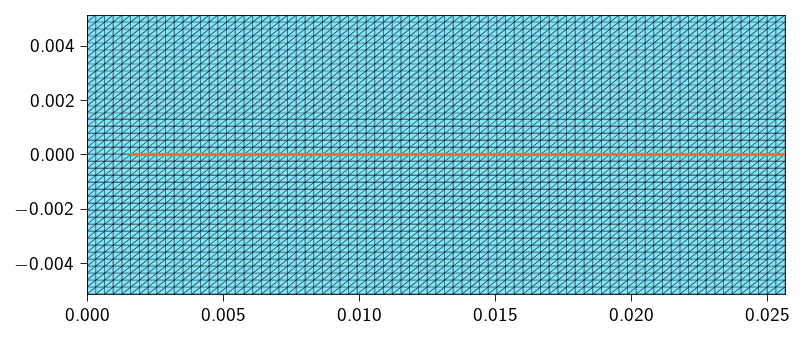

In [115]:
# | code-fold: true
# | fig-align: center
# | fig-cap: "Mesh with cohesive elements"
# | code-summary: "Code: Plot the mesh with cohesive elements"

plt.style.use(STYLE_PATH)
plt.figure(figsize=(6, 3))
ax = plt.axes()
# ax.triplot(coords[:, 0], coords[:, 1], elements, color="grey", lw=0.5)
ax.tripcolor(
    upper_coords[:, 0],
    upper_coords[:, 1],
    upper_elements_2d,
    edgecolors="black",
    linewidths=0.2,
    shading="flat",
    cmap=cmc.managua_r,
    facecolors=np.ones(upper_elements_2d.shape[0]),
)

ax.tripcolor(
    lower_coords[:, 0],
    lower_coords[:, 1],
    lower_elements_2d,
    edgecolors="black",
    linewidths=0.2,
    shading="flat",
    cmap=cmc.managua_r,
    facecolors=np.zeros(lower_elements_2d.shape[0]),
)


# Highlight the extracted 1D elements in red
for edge in upper_elements_1d:
    ax.plot(upper_coords[edge, 0], upper_coords[edge, 1], colors.red, lw=1.5)

ax.set_aspect("equal")
ax.margins(0, 0)
plt.show()

To check that the elements along the cohesive line are in same order on both
surface, we compare the node values for the two.


In [10]:
jnp.allclose(mesh.coords[upper_elements_1d], mesh.coords[lower_elements_1d], atol=1e-6)

Array(True, dtype=bool)

## Defining total potential energy

The total potential energy $\Psi$ is the sum of the elastic strain energy
$\Psi_{elastic}$ and the cohesive energy $\Psi_{cohesive}$.

$$\Psi(u)=\Psi_\text{elastic}(u)+\Psi_\text{cohesive}(u)$$


We define a function to compute the linear elastic energy density based on the
displacement gradients $\nabla u$.

$$
\psi_\text{elastic}(x) =  \sigma(x) : \epsilon(x)
$$

where $\sigma$ is the stress tensor and $\epsilon$ is the strain tensor.

$$
\sigma = \lambda \text{tr}(\epsilon) I + 2\mu \epsilon
$$

and

$$
\epsilon = \frac{1}{2} (\nabla u + \nabla u^T)
$$

The elastic strain energy density is then given by:

$$
\Psi_\text{elastic}(u) = \int_{\Omega} \psi_\text{elastic}(x) dV
$$


In [15]:
tri = element.Tri3()
op = Operator(mesh, tri)

In [16]:
from typing import NamedTuple

class Material(NamedTuple):
    """Material properties for the elasticity operator."""

    mu: float  # Diffusion coefficient
    lmbda: float  # Diffusion coefficient


mat = Material(mu=mu, lmbda=lmbda)

In [17]:
# --- Material model (linear elasticity: plane strain) ---
@auto_vmap(grad_u=2)
def compute_strain(grad_u):
    return 0.5 * (grad_u + grad_u.T)


@auto_vmap(eps=2, mu=0, lmbda=0)
def compute_stress(eps, mu, lmbda):
    I = jnp.eye(2)
    return 2 * mu * eps + lmbda * jnp.trace(eps) * I


@auto_vmap(grad_u=2, mu=0, lmbda=0)
def strain_energy(grad_u, mu, lmbda):
    eps = compute_strain(grad_u)
    sigma = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.einsum("ij,ij->", sigma, eps)

In [18]:
@op.integrate
def total_strain_energy(u: Array, u_grad: Array, *_) -> Array:
    """Compute the total energy of the system."""
    return strain_energy(u_grad, mat.mu, mat.lmbda)

Now we prepare the mesh and the boundary conditions and solve the linear
elasticity problem.


The cohesive energy is defined as:

$$\Psi_\text{cohesive}(u)= \int_{\Gamma_\text{coh}} \psi(\delta( [\![\boldsymbol{u}]\!])) d\Gamma$$

where

- $\Gamma_\text{coh}$ is the cohesive interface.

- $\boldsymbol{\delta}(\boldsymbol{u}) = f([\![\boldsymbol{u}]\!])$ is
  the displacement jump across the interface.

- $\psi(\boldsymbol{\delta})$ is the cohesive potential, which defines the 
  energy-separation relationship.


In [31]:
class CohesiveMaterial(NamedTuple):
    """Material properties for the elasticity operator."""

    Gamma: float  # Fracture energy
    sigma_c: float  # Critical stress
    penalty: float  # Penalty parameter


cohesive_mat = CohesiveMaterial(Gamma=Gamma, sigma_c=sigma_c, penalty=1e3)

For this exercise, we chose an exponential cohesive potential:

$$
\psi(\delta) = \frac{1}{2} \Gamma \left(1 - ( 1 + \frac{\delta}{\delta_c})  \exp\left(-\frac{\delta}{\sigma_c}\right)\right)
$$

where $\Gamma$ is the fracture energy, $\sigma_c$ is the critical stress, $\delta_c$ is the effective crack opening at which critical stress is reached and $\delta$ is the effective crack opening. The critical opening for the exponential cohesive potential is given as 

$$
\delta_c =  \Gamma \exp(-1)  / \sigma_c
$$


We define the effective crack opening as:

$$
\delta = \sqrt{ ([\![\boldsymbol{u}]\!] \cdot{}\boldsymbol{t})^2 + ([\![\boldsymbol{u}]\!] \cdot \boldsymbol{n})^2 }
$$

where $\boldsymbol{t}$ is the tangential direction (which for this problem is the $x$-direction) and $\boldsymbol{n}$ is the normal direction to the cohesive interface (which for this problem is the $y$-direction).



The cohesive energy is then given by:

$$
\Psi_\text{cohesive}(u)= \int_{\Gamma_\text{coh}} \psi(\delta( [\![\boldsymbol{u}]\!])) d\Gamma$$

In [32]:
@jax.jit
def safe_sqrt(x):
    return jnp.sqrt(jnp.where(x > 0., x, 0.))


@auto_vmap(jump=1)
def compute_opening(jump: Array) -> float:
    """
    Compute the opening of the cohesive element.
    Args:
        jump: The jump in the displacement field.
    Returns:
        The opening of the cohesive element.
    """
    opening = safe_sqrt(jump[0] ** 2 + jump[1] ** 2)
    return opening


@auto_vmap(jump=1)
def exponential_cohesive_energy(
    jump: Array,
    Gamma: float,
    sigma_c: float,
    penalty: float,
    delta_threshold: float = 1e-8,
) -> float:
    """
    Compute the cohesive energy for a given jump. 
    Args:
        jump: The jump in the displacement field.
        Gamma: Fracture energy of the material.
        sigma_c: The critical strength of the material.
        penalty: The penalty parameter for penalizing the interpenetration.
        delta_threshold: The threshold for the delta parameter.
    Returns:
        The cohesive energy.
    """
    delta = compute_opening(jump)
    delta_c = (Gamma * jnp.exp(-1)) / sigma_c

    def true_fun(delta):
        return Gamma * (1 - (1 + (delta / delta_c)) * (jnp.exp(-delta / delta_c)))

    def false_fun(delta):
        return 0.5 * penalty * delta**2

    return jax.lax.cond(delta > delta_threshold, true_fun, false_fun, delta)


We define a new `Line` element to integrate the cohesive energy. The `Line` element is a 1D element that is used to integrate the cohesive energy across the cohesive interface. We chose the bottom interface to integrate the cohesive energy. We could have chosen the top interface as well. Since both interface are identical, we can choose either one.

To ease the integration along the cohesive line, we define a new mesh that consists of line elements (or interface elements) from the bottom interface.

In [33]:
#| code-fold: true
#| code-summary: "Code: Generate the interface mesh"

def generate_interface_mesh(mesh, line_elements):
    """Generate a mesh for the interface between two materials."""

    # --- Interface mesh ---
    line_element_nodes = jnp.unique(line_elements.flatten())
    interface_coords = mesh.coords[line_element_nodes]
    interface_elements = jnp.array(
        [[index, index + 1] for index in range(len(line_elements))]
    )

    interface_mesh = Mesh(interface_coords, interface_elements)
    return interface_mesh

In [34]:
interface_mesh = generate_interface_mesh(mesh, lower_elements_1d)
line = element.Line2()
line_op = Operator(interface_mesh, line)

Now, we can define the function that will be integrated along the cohesive line. We will need the node indices of the top and bottom interface to compute the jump vector $[\![\boldsymbol{u}]\!]$. This jump vector will then be interpolated at the quadrature points along the cohesive line and integrated.

In [35]:
bottom_cohesive_nodes = jnp.unique(lower_elements_1d.flatten())
top_cohesive_nodes = jnp.unique(upper_elements_1d.flatten())

In [36]:
@line_op.integrate
def _total_cohesive_energy(u: Array, u_grad: Array, *_) -> float:
    return exponential_cohesive_energy(
        u, cohesive_mat.Gamma, cohesive_mat.sigma_c, cohesive_mat.penalty
    )

@jax.jit
def total_cohesive_energy(u_flat: Array) -> float:
    u = u_flat.reshape(-1, n_dofs_per_node)
    jump = u.at[top_cohesive_nodes, :].get() - u.at[bottom_cohesive_nodes, :].get()
    return _total_cohesive_energy(jump)

Finally, we can put everything together to compute the total energy.


In [37]:
@jax.jit
def total_energy(u_flat: Array) -> float:
    u = u_flat.reshape(-1, n_dofs_per_node)
    elastic_strain_energy = total_strain_energy(u)

    cohesive_energy = total_cohesive_energy(u)
    return elastic_strain_energy + cohesive_energy


We now locate the dofs in the two domains to apply boundary conditions. We load the domain under Model I loading where both the top and bottom surfaces are loaded along the $y$-direction only. Furthermore, we assume symmetry about the $x$-axis at the left edge of the domain. Under symmetry, the domain represents a thorough crack in the middle of the domain. So the boundary conditions are:

- $u_x = 0$ on the left edge
- $u_y = -H\varepsilon_0/2$ on the bottom edge ($u_x = 0$)
- $u_y = H\varepsilon_0/2$ on the top edge ($u_x = 0$)

where $H$ is the height of the domain and $\varepsilon_0$ is the applied prestrain.


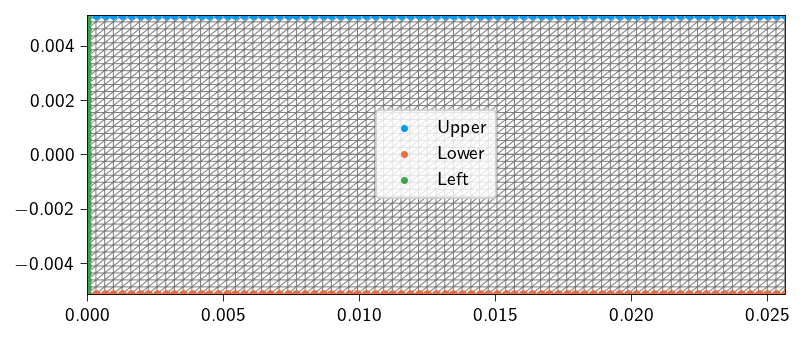

In [ ]:
#| code-fold: true
#| code-summary: "Code: Define the boundary conditions"
#| fig-cap: "Mesh with boundary conditions"
#| fig-align: center

y_max = jnp.max(mesh.coords[:, 1])
y_min = jnp.min(mesh.coords[:, 1])
x_min = jnp.min(mesh.coords[:, 0])
height = y_max - y_min


upper_nodes = jnp.where(jnp.isclose(mesh.coords[:, 1], y_max))[0]
lower_nodes = jnp.where(jnp.isclose(mesh.coords[:, 1], y_min))[0]
left_nodes = jnp.where(jnp.isclose(mesh.coords[:, 0], x_min))[0]

fixed_dofs = jnp.concatenate(
    [
        2 * upper_nodes,
        2 * upper_nodes + 1,
        2 * lower_nodes,
        2 * lower_nodes + 1,
        2 * left_nodes,
    ]
)



applied_disp = 1.0* prestrain * height

prescribed_values = jnp.zeros(n_dofs).at[2 * upper_nodes].set(0.0)
prescribed_values = prescribed_values.at[2 * upper_nodes + 1].set(applied_disp / 2.0)
prescribed_values = prescribed_values.at[2 * lower_nodes].set(0.0)
prescribed_values = prescribed_values.at[2 * lower_nodes + 1].set(-applied_disp / 2.0)

free_dofs = jnp.setdiff1d(jnp.arange(n_dofs), fixed_dofs)


# We plot the mesh the nodes that are fixed on the left and right edges.

plt.style.use(STYLE_PATH)
plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.triplot(mesh.coords[:, 0], mesh.coords[:, 1], mesh.elements, color="grey", lw=0.5)

ax.scatter(mesh.coords[upper_nodes, 0], mesh.coords[upper_nodes, 1], s=10, label="Upper")
ax.scatter(mesh.coords[lower_nodes, 0], mesh.coords[lower_nodes, 1], s=10, label="Lower")
ax.scatter(mesh.coords[left_nodes, 0], mesh.coords[left_nodes, 1], s=10, label="Left")
ax.legend()
ax.set_aspect("equal")
ax.legend(loc="center")
ax.margins(0.0, 0.0)
plt.show()

## Using matrix-free solver

Now, we define a few functions to implement the matrix-free solvers. We will use the conjugate gradient method to solve the linear system of equations. The Dirichlet boundary conditions are applied using projection method.

In [39]:
# creating functions to compute the gradient and
gradient = jax.jacrev(total_energy)

In [40]:
# | code-fold: true
# | code-summary: "Code: Functions to implement the matrix-free solvers"

def compute_tangent(dx, x):
    tangent = jax.jvp(gradient, (x,), (dx,))[1]
    tangent = tangent.at[fixed_dofs].set(0)
    return tangent


@eqx.filter_jit
def conjugate_gradient(A, b, atol=1e-8, max_iter=100):

    iiter = 0

    def body_fun(state):
        b, p, r, rsold, x, iiter = state
        Ap = A(p)
        alpha = rsold / jnp.vdot(p, Ap)
        x = x + jnp.dot(alpha, p)
        r = r - jnp.dot(alpha, Ap)
        rsnew = jnp.vdot(r, r)
        p = r + (rsnew / rsold) * p
        rsold = rsnew
        iiter = iiter + 1
        return (b, p, r, rsold, x, iiter)

    def cond_fun(state):
        b, p, r, rsold, x, iiter = state
        return jnp.logical_and(jnp.sqrt(rsold) > atol, iiter < max_iter)

    x = jnp.full_like(b, fill_value=0.0)
    r = b - A(x)
    p = r
    rsold = jnp.vdot(r, p)

    b, p, r, rsold, x, iiter = jax.lax.while_loop(
        cond_fun, body_fun, (b, p, r, rsold, x, iiter)
    )
    return x, iiter


def newton_krylov_solver(
    u,
    fext,
    gradient,
    fixed_dofs,
):
    fint = gradient(u)

    du = jnp.zeros_like(u)

    iiter = 0
    norm_res = 1.0

    tol = 1e-8
    max_iter = 10

    while norm_res > tol and iiter < max_iter:
        residual = fext - fint
        residual = residual.at[fixed_dofs].set(0)
        A = eqx.Partial(compute_tangent, x=u)
        du, cg_iiter = conjugate_gradient(
            A=A, b=residual, atol=1e-8, max_iter=100
        )

        u = u.at[:].add(du)
        fint = gradient(u)
        residual = fext - fint
        residual = residual.at[fixed_dofs].set(0)
        norm_res = jnp.linalg.norm(residual)
        print(f"  Residual: {norm_res:.2e}")
        iiter += 1

    return u, norm_res

In [41]:
#| output: false

u_prev = jnp.zeros(n_dofs)
fext = jnp.zeros(n_dofs)

n_steps = 100

force_on_top = []
displacement_on_top = []
u_per_step = []

force_on_top.append(0)
displacement_on_top.append(0)
u_per_step.append(u_prev.reshape(n_nodes, n_dofs_per_node))

du_total = prescribed_values / n_steps  # displacement increment

for step in range(n_steps):
    print(f"Step {step+1}/{n_steps}")
    u_prev = u_prev.at[fixed_dofs].add(du_total[fixed_dofs])

    u_new, rnorm = newton_krylov_solver(
        u_prev,
        fext,
        gradient,
        fixed_dofs,
    )

    u_prev = u_new
    force_on_top.append(jnp.sum(gradient(u_prev)[2 * upper_nodes + 1]))
    displacement_on_top.append(jnp.mean(u_prev[2 * upper_nodes + 1]))
    u_per_step.append(u_prev.reshape(n_nodes, n_dofs_per_node))

u_solution = u_prev.reshape(n_nodes, n_dofs_per_node)

Step 1/100
  Residual: 1.46e+01
  Residual: 1.06e+00
  Residual: 6.13e-03
  Residual: 3.71e-04
  Residual: 1.63e-05
  Residual: 1.31e-06
  Residual: 6.33e-08
  Residual: 9.75e-09
Step 2/100
  Residual: 9.09e-02
  Residual: 8.27e-03
  Residual: 5.82e-04
  Residual: 6.22e-05
  Residual: 4.80e-06
  Residual: 5.33e-07
  Residual: 4.19e-08
  Residual: 9.87e-09
Step 3/100
  Residual: 9.10e-02
  Residual: 8.28e-03
  Residual: 5.81e-04
  Residual: 6.21e-05
  Residual: 4.79e-06
  Residual: 5.31e-07
  Residual: 4.18e-08
  Residual: 9.86e-09
Step 4/100
  Residual: 9.12e-02
  Residual: 8.28e-03
  Residual: 5.81e-04
  Residual: 6.20e-05
  Residual: 4.79e-06
  Residual: 5.30e-07
  Residual: 4.17e-08
  Residual: 9.86e-09
Step 5/100
  Residual: 9.13e-02
  Residual: 8.28e-03
  Residual: 5.81e-04
  Residual: 6.19e-05
  Residual: 4.78e-06
  Residual: 5.28e-07
  Residual: 4.16e-08
  Residual: 9.85e-09
Step 6/100
  Residual: 9.14e-02
  Residual: 8.28e-03
  Residual: 5.81e-04
  Residual: 6.17e-05
  Residual

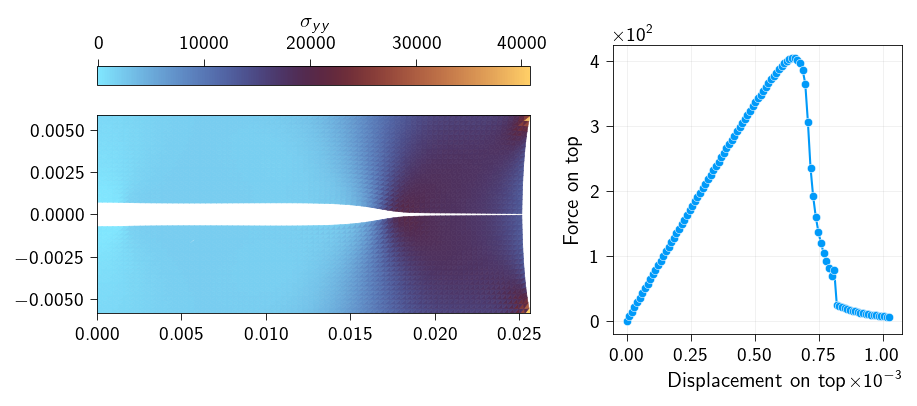

In [42]:
# | code-fold: true
# | fig-align: center
# | fig-cap: "Snapshot of deformed configuration with crack propagation and force-displacement curve."
# | code-summary: "Code: Plot the deformed configuration and the force-displacement curve"

from matplotlib.gridspec import GridSpec
from tools import plot_element_values, plot_nodal_values

# squeeze to remove the quad point dimension (only 1 quad point)
step_number = -30
grad_u = op.grad(u_per_step[step_number]).squeeze()
strains = compute_strain(grad_u)
stresses = compute_stress(strains, mat.mu, mat.lmbda)

fig = plt.figure(layout="constrained", figsize=(6, 4))

gs = GridSpec(1, 2, figure=fig, width_ratios=[0.6, 0.4], wspace=0.05)

ax = fig.add_subplot(gs[0, 0])
plot_element_values(
    u_per_step[step_number], mesh, values=stresses[:, 1, 1].flatten(), ax=ax, label=r"$\sigma_{yy}$"
)
#ax.set_aspect("equal")
ax.set_aspect(1/ax.get_data_ratio())
ax.margins(0, 0)

ax = fig.add_subplot(gs[0, 1])
ax.plot(displacement_on_top, force_on_top, "o-")
ax.set_aspect(1/ax.get_data_ratio())
ax.set_xlabel("Displacement on top")
ax.set_ylabel("Force on top")
ax.grid(True)
ax.ticklabel_format(axis="both", style="sci", scilimits=(1, -4))

plt.show()

Now, let us see how evolution of the crack tip opening along the cohesive line looks like. We compute the jump  $[\![\boldsymbol{u}]\!]$ vector at each quadrature point along the cohesive line. We use the `line_op` operator, defined earlier, to evaluate the jump at the quadrature points of the cohesive line. The quadrature points coordinates are also calculated using the `line_op` operator. 




In [43]:
quadrature_points = line_op.eval(mesh.coords[bottom_cohesive_nodes]).squeeze()

The jump vector is defined as:

$$
[\![\boldsymbol{u}]\!] = \boldsymbol{u}_+ - \boldsymbol{u}_-
$$

where $\boldsymbol{u}_+$ and $\boldsymbol{u}_-$ are the displacement vectors at the top and bottom of the cohesive line, respectively. Below, we show how to use the `eval` method of the `line_op` operator to compute the jump vector at the quadrature points along the cohesive line. We use the the last solution of the quasistatic problem to compute the jump vector.

In [44]:
opening_quadrature = line_op.eval(
    u_solution[top_cohesive_nodes] - u_solution[bottom_cohesive_nodes]
).squeeze()

Now,we do the same for each step of the quasistatic problem. We plot the jump vector at the quadrature points along the cohesive line for each step.

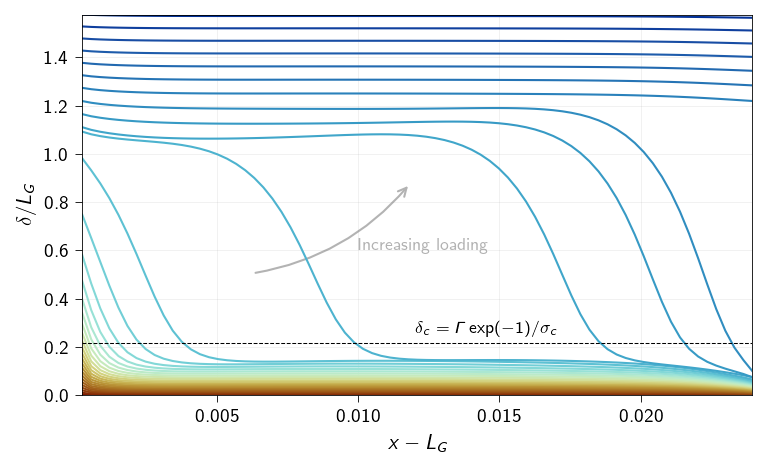

In [106]:
# | code-fold: true
# | code-summary: "Code: Plot the opening along the cohesive line"
# | fig-cap: "Opening along the cohesive line at different loading steps"
# | fig-align: center

plt.style.use(STYLE_PATH)
plt.figure(figsize=(5, 3), layout="constrained")
ax = plt.axes()


quadrature_points = line_op.eval(mesh.coords[bottom_cohesive_nodes]).squeeze()

steps_to_plot = np.arange(0, n_steps, step=3)

mycolor = cmc.roma(np.linspace(0, 1, len(steps_to_plot)))
for i, c in zip(steps_to_plot, mycolor):
    opening_quadrature = line_op.eval(
        u_per_step[i][top_cohesive_nodes] - u_per_step[i][bottom_cohesive_nodes]
    ).squeeze()

    ax.plot(
        quadrature_points[:, 0] - crack_length,
        opening_quadrature[:, 1] / L_G,
        label=f"Step {i+1}",
        c=c,
    )


ax.axhline(
    cohesive_mat.Gamma * np.exp(-1) / cohesive_mat.sigma_c / L_G,
    color="black",
    linewidth=0.5,
    ls="--",
)
ax.text(
    0.012,
    1.2 * cohesive_mat.Gamma * np.exp(-1) / cohesive_mat.sigma_c / L_G,
    r"$\delta_c=\Gamma \exp(-1) / \sigma_c$",
    color="black",
    fontsize=8,
)
ax.annotate("",
                xy=(0.006, 0.5), xycoords='data',
                xytext=(0.012, 0.9), textcoords='data',
                arrowprops=dict(arrowstyle="<-", color="0.7",
                                shrinkA=5, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle="arc3,rad=-0.2",
                                ),
                                zorder=-100,
                )
ax.text(0.010, 0.6, r"Increasing loading", color="0.7", fontsize=8)

ax.set_xlabel(r"$x -L_G$")
ax.set_ylabel(r"$\delta/L_G$")
ax.grid(True)
ax.margins(0.0, 0.0)
plt.show()

::: {.callout-important}
One can use sparse solvers for cohesive elements. However, the sparsity pattern needs to be created manually. By naively creating the sparsity pattern based on the constraint elements along the interface, we can create a sparse matrix but our analysis shows that such a sparsity pattern is not correct. 

Below, we show how the sparsity pattern created naively leads to a wrong stiffness matrix.
:::


### Generating sparsity pattern

In [ ]:
@auto_vmap(lower_element=1, upper_element=1)
def get_constrained_elements(lower_element, upper_element):
    return jnp.array(
        [lower_element[0], lower_element[1], upper_element[1], upper_element[0]]
    )

In [100]:
constrained_elements = get_constrained_elements(upper_elements_1d, lower_elements_1d)

sparsity_pattern = sparse.create_sparsity_pattern(
    mesh, n_dofs_per_node=n_dofs_per_node, constraint_elements=constrained_elements
)


lower_element: 0


To show that the problem is with the chosen sparsity pattern, we create another sparsity pattern based on the dense Hessian matrix.

In [ ]:
sparsity_pattern_2 = jax.experimental.sparse.BCOO.fromdense(
    hessian(u_solution.flatten()*0.)
)

The difference between the two sparsity pattern is shown in the figure below.

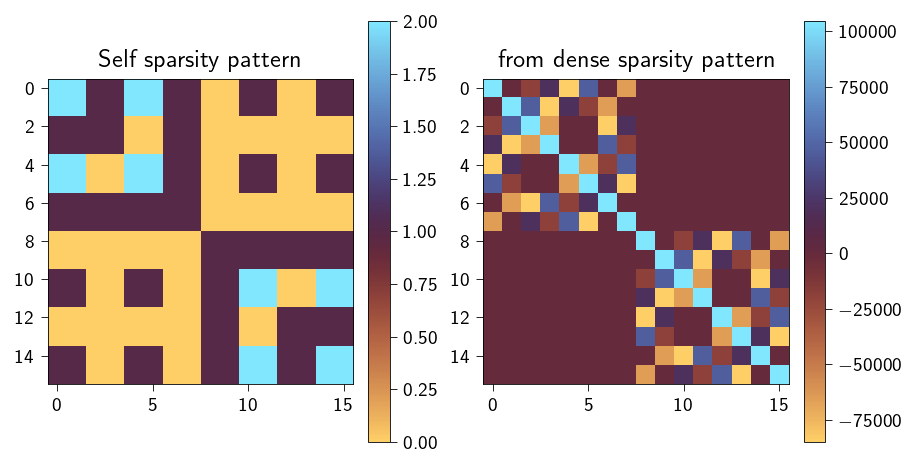

In [ ]:
#| code-fold: true
#| fig-align: center
#| fig-cap: "Sparsity pattern from constraint elements approach and from dense stiffness matrix"
#| code-summary: "Code: Plot the sparsity pattern"

from matplotlib.gridspec import GridSpec
from tools import plot_element_values, plot_nodal_values

plt.style.use(STYLE_PATH)

fig, axs = plt.subplots(1, 2, layout="constrained", figsize=(6, 3))

cb = axs[0].imshow(sparsity_pattern.todense())
axs[0].set_title("Self sparsity pattern")
fig.colorbar(cb, ax=axs[0])
cb = axs[1].imshow(sparsity_pattern_2.todense())
axs[1].set_title("from dense sparsity pattern")
fig.colorbar(cb, ax=axs[1])

plt.show()


### Comparing dense stiffness matrix with sparse stiffness matrix

Now lets us compare the stiffness matrix constructed from the sparsity pattern to the dense stiffness matrix.

In [103]:
hessian_sparse = sparse.jacfwd(
    jax.jacrev(total_energy), sparsity_pattern=sparsity_pattern
)

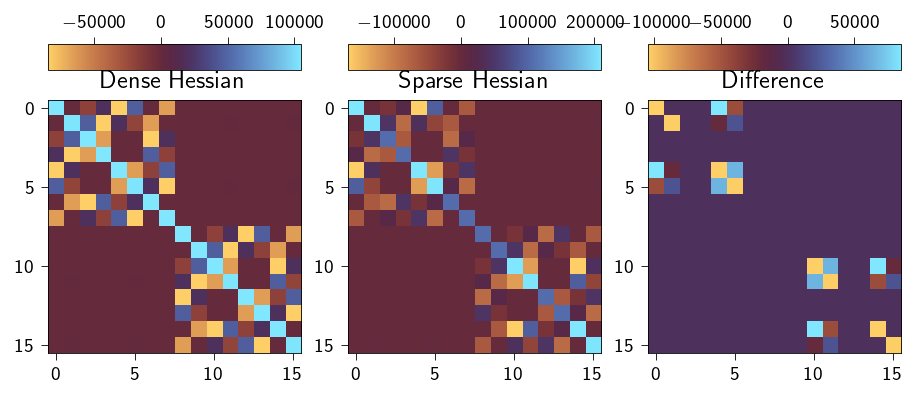

In [ ]:
#| code-fold: true
#| fig-align: center
#| fig-cap: "Stiffness matrix comparison between dense and sparse approach"
#| code-summary: "Code: Plot the stiffness matrix"

from mpl_toolkits.axes_grid1 import make_axes_locatable


K_dense =  hessian(u_solution.flatten())
K_sparse = hessian_sparse(u_solution.flatten())

plt.style.use(STYLE_PATH)
fig, axs = plt.subplots(1, 3, layout="constrained", figsize=(6, 3))

cb = axs[0].imshow(K_dense)
axs[0].set_title("Dense Hessian")
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("top", size="10%", pad=0.2)
fig = axs[0].get_figure()
fig.colorbar(cb, cax=cax,  orientation="horizontal", location="top")

cb = axs[1].imshow(K_sparse.todense())
axs[1].set_title("Sparse Hessian")
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("top", size="10%", pad=0.2)
fig = axs[1].get_figure()
fig.colorbar(cb, cax=cax, orientation="horizontal", location="top")

cb = axs[2].imshow(K_dense - K_sparse.todense())
axs[2].set_title("Difference")
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("top", size="10%", pad=0.2)
fig = axs[2].get_figure()
fig.colorbar(cb, cax=cax, orientation="horizontal", location="top")

plt.show()

In [105]:
np.allclose(K_sparse.todense(), K_dense, atol=1e-10)

False

### Sparse Solver (Using Scipy)

In [ ]:
import scipy.sparse as sp
from time import perf_counter

def newton_scipy_solver(
    u,
    fext,
    gradient,
    hessian_sparse,
    fixed_dofs,
    free_dofs,
    zero_indices,
    one_indices,
):
    fint = gradient(u)

    iiter = 0
    norm_res = 1.0

    tol = 1e-8
    max_iter = 10

    while norm_res > tol and iiter < max_iter:
        residual = fext - fint
        residual = residual.at[fixed_dofs].set(0)

        K_sparse = hessian_sparse(u)
        K_data_lifted = K_sparse.data.at[zero_indices].set(0)
        K_data_lifted = K_data_lifted.at[one_indices].set(1)

        K_csr = sp.csr_matrix(
            (K_data_lifted, (K_sparse.indices[:, 0], K_sparse.indices[:, 1]))
        )

        du = sp.linalg.spsolve(K_csr, residual)

        u = u.at[:].add(du)

        fint = gradient(u)

        residual = fext - fint
        residual_free = residual.at[free_dofs].get()
        norm_res = jnp.linalg.norm(residual_free)
        print(f"  Residual: {norm_res:.2e}")

        iiter += 1

    return u, norm_res